In [1]:
import os
import glob
import time
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 경로 설정
base_path = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10'
generated_samples_path = os.path.join(base_path, 'generated_samples')
training_checkpoints_path = os.path.join(base_path, 'training_checkpoints')
training_history_path = os.path.join(base_path, 'training_history')

os.makedirs(generated_samples_path, exist_ok=True)
os.makedirs(training_checkpoints_path, exist_ok=True)
os.makedirs(training_history_path, exist_ok=True)

In [3]:
# 데이터셋 로드 및 특정 클래스만 추출
def load_data(label=0):  # 기본값은 클래스 0 (airplane)
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    train_x = train_x[train_y.flatten() == label]
    test_x = test_x[test_y.flatten() == label]
    return train_x, test_x

In [4]:
# 특정 클래스 데이터만 추출 및 정규화
train_x, _ = load_data(label=0)  # 클래스 0 (airplane) 선택
train_x = (train_x - 127.5) / 127.5  # -1 ~ 1로 정규화
train_x = train_x.astype('float32')

In [5]:
train_x.shape

(5000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


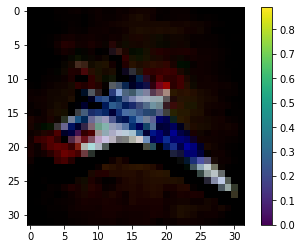

In [6]:
plt.imshow(train_x[1])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

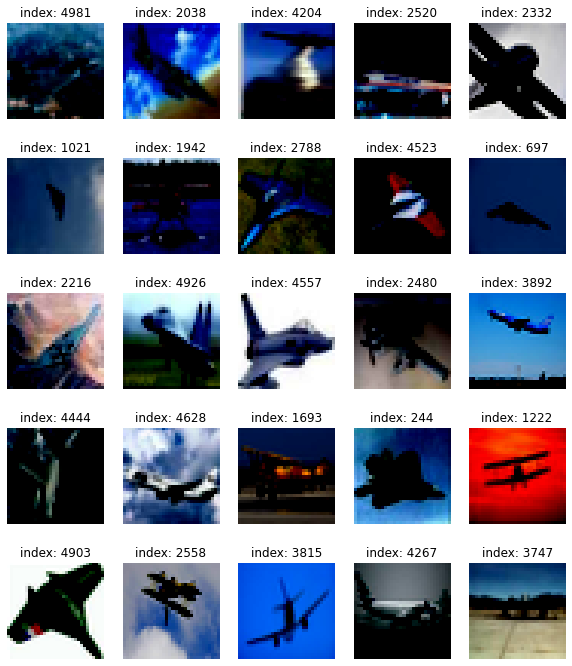

In [7]:
plt.figure(figsize=(10, 12))

for i in range(25):
    index = np.random.randint(1, 5000)
    plt.subplot(5,5, i+1)
    plt.imshow(train_x[index])
    plt.title(f'index: {index}')
    plt.axis('off')
plt.show()

In [8]:
# 데이터셋 준비
BUFFER_SIZE = train_x.shape[0]
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
# 생성자 모델 정의
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [10]:
generator = make_generator_model()

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0

In [12]:
noise = tf.random.normal([1, 100])

In [13]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

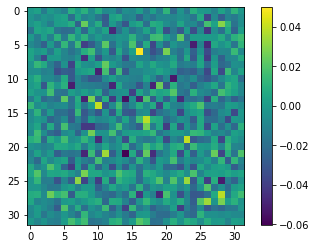

In [14]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [15]:
# 판별자 모델 정의
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

In [16]:
discriminator = make_discriminator_model()

In [17]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [18]:
# 손실 함수 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [19]:
# 정확도 계산 함수
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, 0.5), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, 0.5), tf.float32))
    return real_accuracy, fake_accuracy

In [20]:
# 최적화 도구 설정
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
# 학습 단계 정의
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [22]:
# 이미지 생성 및 저장
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8))
        plt.axis('off')
    plt.savefig(f"{generated_samples_path}/image_at_epoch_{epoch:04d}.png")
    plt.close(fig)

In [23]:
# 학습 기록 저장
gen_loss_history = []  # 생성자 손실 기록
disc_loss_history = []  # 판별자 손실 기록
real_acc_history = []  # 진짜 데이터에 대한 정확도 기록
fake_acc_history = []  # 가짜 데이터에 대한 정확도 기록

In [24]:
# 학습 루프
def train(dataset, epochs, seed):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss, real_acc, fake_acc = train_step(image_batch)
            gen_loss_history.append(gen_loss.numpy())
            disc_loss_history.append(disc_loss.numpy())
            real_acc_history.append(real_acc.numpy())
            fake_acc_history.append(fake_acc.numpy())
        generate_and_save_images(generator, epoch + 1, seed)

In [25]:
# 학습 실행
EPOCHS = 100
seed = tf.random.normal([16, 100])  # 고정된 시드
train(train_dataset, EPOCHS, seed)

In [26]:
# 학습 결과 시각화
def draw_train_history():
    plt.figure(figsize=(12, 10))

    # Loss 그래프
    plt.subplot(2, 1, 1)
    plt.plot(gen_loss_history, label='Generator Loss', color='blue')
    plt.plot(disc_loss_history, label='Discriminator Loss', color='orange')
    plt.title('Model Loss', fontsize=16)
    plt.xlabel('Batch Iterations', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Accuracy 그래프
    plt.subplot(2, 1, 2)
    plt.plot(real_acc_history, label='Real Accuracy', color='orange')
    plt.plot(fake_acc_history, label='Fake Accuracy', color='blue')
    plt.title('Discriminator Accuracy', fontsize=16)
    plt.xlabel('Batch Iterations', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

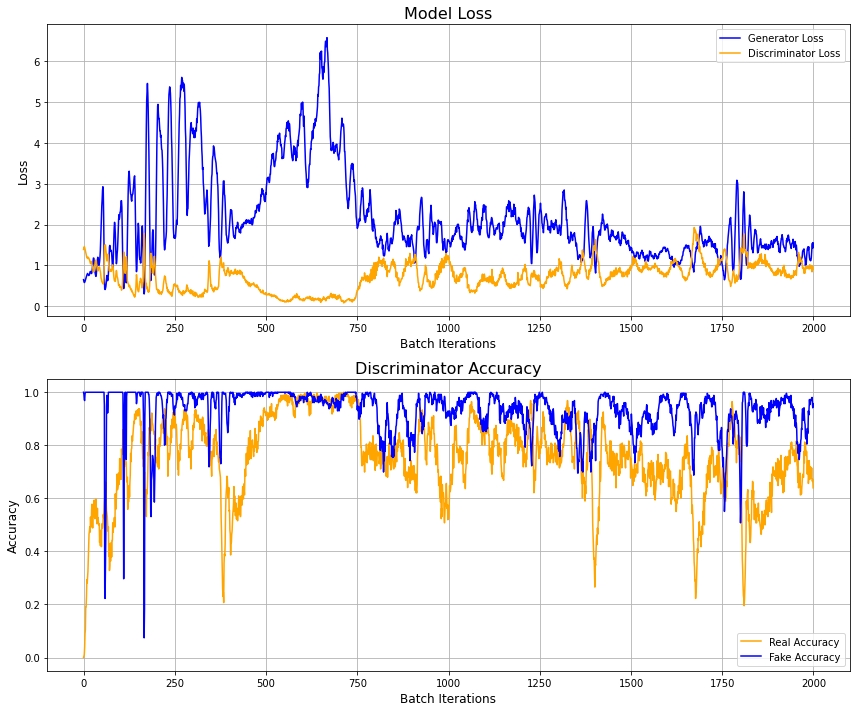

In [27]:
# 학습 과정 결과 확인
draw_train_history()

In [28]:
# GIF 생성
anim_file = f"{base_path}/cifar10_dcgan.gif"
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = sorted(glob.glob(f"{generated_samples_path}/*.png"))
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
!ls -l {anim_file}

-rw-r--r-- 1 root root 3557486 Dec  2 03:26 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif
